In [1]:
import torch
import torch.nn as nn             #muntar xarxes (capes, activacions, backpropagació de gradients...)
import torch.optim as optim       #escollir optimitzador que recalcularà els pesos
import torch.nn.functional as F   #cridar directament a funcions sense acudir a les classes
#import torch.utils.data as data   #muntar dataloaders que generaran els batches de dades
from torch.utils.data import Dataset, DataLoader
import torchvision  #eines diverses per descarregar bases de dades, transformar dades...
from torch.utils.data import random_split

import matplotlib.pyplot as plt   #mostrar, plotejar, displayar dades i imatges

from tqdm import tqdm
import glob
import numpy as np
import cv2
import math

# ASEGURAR QUE SE HA EJECUTADO data_augmentation.py PARA TENER EL DATASET

In [2]:
batch_size =    5                   #per simplificar farem servir mateixa mida per training i test 
learning_rate = 0.001                #tasa d'aprenentatge
momentum =      0.05                #paràmetre pel cas de l'optimitzador SGD (Stochastic gradient descent)
n_epochs =      50                  #vegades que la xarxa veurà totes les dades d'entrenament
train_test_ratio = 0.8
img_dim = (256,256)

criterium = nn.MSELoss() #loss function
#criterium = nn.CrossEntropyLoss() #loss function
#criterium = nn.L1Loss() #loss function

In [3]:
class CustomDataset(Dataset):
    def __init__(self, path):
        self.imgs_path = path
        file_list = glob.glob(self.imgs_path + "*")
        #print(file_list)
        self.data = []
        for class_path in file_list:
            class_name = class_path[len(path):]
            for img_path in glob.glob(class_path + "/*.png"): #si falla algo puede ser por la extension de los archivos
                self.data.append([img_path, class_name])

        self.class_map = {"negatiu" : 0.0, "positiu": 1.0, "tijeras": 2.0}
        self.img_dim = img_dim

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor.permute(2, 0, 1)  #channel in first component
        class_id = torch.tensor([class_id])
        # Cambiar segun la loss function
        #return img_tensor, class_id
        return img_tensor.float(), class_id.float()
        #return img_tensor.float(), class_id
    
    def info(self):
        print(f"Classes: {self.class_map}")
        print(f"Length: {len(dataset)}")
        print(f"Root path: {self.imgs_path}")

In [4]:
dataset = CustomDataset("augmented_data/")
dataset.info()

Classes: {'negatiu': 0.0, 'positiu': 1.0, 'tijeras': 2.0}
Length: 216
Root path: augmented_data/


In [5]:
n_train = math.ceil(len(dataset)*train_test_ratio)
n_test = len(dataset) - n_train
print(f"Tamaño conjuntos train y test: {(n_train,n_test)}")

train_data, test_data = random_split(dataset, [n_train, n_test])
train_loader = DataLoader(train_data,batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True) #no_workers, pin_memory, drop_last

Tamaño conjuntos train y test: (173, 43)


torch.Size([3, 256, 256])


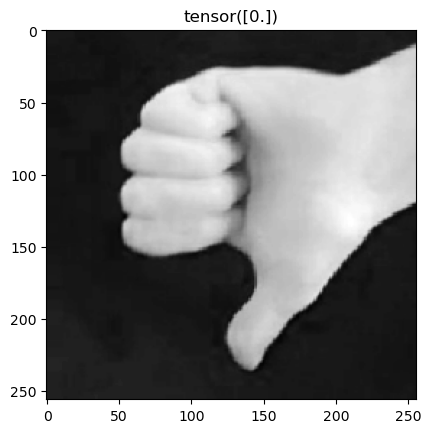

In [6]:
# exemple de mostra
idx = 3                       #un qualsevol per veure com són
input_example,target_example = train_data.__getitem__(idx)
print(input_example.size())       #mida de cada mostra/imatge/digit
plt.imshow(input_example[0,:,:], cmap='gray')
plt.title(str(target_example))
plt.show()

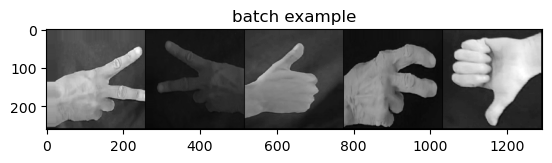

tensor([[2.],
        [2.],
        [1.],
        [2.],
        [0.]])


In [7]:
# exemple de batch
dataiter = iter(train_loader)
batch_images_example, batch_labels_example = next(dataiter)

plt.imshow(torchvision.utils.make_grid(batch_images_example)[0,:,:], cmap='gray')
plt.title('batch example')
plt.show()
print(batch_labels_example)

In [8]:
in_channels = 3   # RGB
n1_kernels = 40   # nombre de kernels de la primera convolucio
n2_kernels = 60   # nombre de kernels de la segona convolucio
# falta generalitzar la inicialització per a un tamany de kernel arbitrari, actualment tamany de 5

# definició de la xarxa
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels,n1_kernels,5)   #def convolutonal layer (in_channels, out_channels, kernel_size)
        self.conv2 = nn.Conv2d(n1_kernels,n2_kernels,5)  #def convolutonal layer 
        self.fc1 = nn.Linear(int((((img_dim[0]-4)/2-4)/2)*(((img_dim[1]-4)/2-4)/2)*n2_kernels),50)  #def fully connected layer
        self.fc2 = nn.Linear(50,3)      #def fully connected layer

    def forward(self, x):         #size [batch,channels,height,width] = [5,3,256,256]
        x = F.relu(self.conv1(x)) #size [5,3,252,252] padding effect
        x = F.max_pool2d(x,2)     #size [5,40,126,126] downsampling
        x = F.relu(self.conv2(x)) #size [5,60,122,122]   padding effect
        x = F.max_pool2d(x,2)     #size [5,60,61,61]   downsampling
        x = torch.flatten(x,1)    #flatten all dimensions except batch
        x = F.relu(self.fc1(x))   #size [5,223260]
        x = self.fc2(x)           #size [5,50]
        return x                  #size [5,3]  

In [9]:
# instanciació de la xarxa i l'optimitzador
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [10]:
# variables per graficar resultats
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [11]:
# definició dels bucles d'aprenentatge i test (validació)
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        print(output)
        output,_ = torch.max(output, dim=1)
        target = target.resize(target.shape[0])
        _,pred = torch.max(output.data,0) #?
        loss = criterium(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:      #mostra log cada 100 batches
            print('epoch: {:2d} [{:5d}/{} ({:3.0f}%)]\tloss: {:.6f}'.format(
            epoch+1, batch_idx*len(data), len(train_loader.dataset),
            100.0*batch_idx/len(train_loader), loss.item()/batch_size))
            train_losses.append(loss.item()/batch_size)
            train_counter.append(batch_idx*batch_size+epoch*len(train_loader.dataset))

def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            #print(data)
            output = network(data)
            print(output)
            output,_ = torch.max(output, dim=1)
            print(output)
            target = target.resize(target.shape[0])
            #print(criterium(output, target))
            test_loss += criterium(output, target)
            _,pred = torch.max(output.data,0)
            #print(pred)
            correct += (pred == target).sum().item() 
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss.item())
    print('\nTest set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:5.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),100.0*correct/len(test_loader.dataset)))    
    return correct  

In [12]:
# llencem els experiments
test()
for epoch in range(n_epochs):
    train(epoch)
    correct = test()

tensor([[-2.3695,  4.6613,  1.7695],
        [-0.6829,  2.6177,  1.0176],
        [-1.5423,  1.0852,  0.8540],
        [-1.3159,  3.6279,  0.9095],
        [-3.4964,  1.1010,  3.1502]])
tensor([4.6613, 2.6177, 1.0852, 3.6279, 3.1502])
tensor([[-5.5072,  1.1515,  1.7202],
        [-3.3722,  0.5091,  1.8433],
        [-1.6341, -0.0838,  0.2459],
        [-3.0707,  5.8040,  1.7107],
        [-1.5449,  0.2590,  0.6421]])
tensor([1.7202, 1.8433, 0.2459, 5.8040, 0.6421])


C:\Users\javie\anaconda3\envs\spyder-env\lib\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


tensor([[-2.0258,  0.3835,  1.1495],
        [-2.2363,  0.7855,  0.9535],
        [-0.8401, -0.5597, -0.0660],
        [-0.6950,  0.6480,  0.6714],
        [-4.8343, -0.6600,  0.5437]])
tensor([ 1.1495,  0.9535, -0.0660,  0.6714,  0.5437])
tensor([[-3.7794,  2.6496,  2.8354],
        [-3.3689,  2.7448,  0.9788],
        [-3.9443,  1.2812,  1.6374],
        [-2.3096, -0.5075,  2.4380],
        [-4.8673, -3.7512, -1.6532]])
tensor([ 2.8354,  2.7448,  1.6374,  2.4380, -1.6532])
tensor([[-3.2093,  0.2039,  1.7651],
        [-1.4522,  1.3567,  0.4986],
        [-1.6317,  2.1065,  1.4827],
        [-1.3986, -0.8655, -0.4153],
        [-1.2293, -0.6038,  1.2597]])
tensor([ 1.7651,  1.3567,  2.1065, -0.4153,  1.2597])
tensor([[-3.1552, -1.9449, -0.0233],
        [-0.3096,  0.1727, -0.1783],
        [-1.2787,  1.9935,  1.3912],
        [-0.9353,  1.3413,  0.9234],
        [-0.9497, -0.7221,  0.1402]])
tensor([-0.0233,  0.1727,  1.9935,  1.3413,  0.1402])
tensor([[-1.9328,  1.3305,  0.2082],
   

KeyboardInterrupt: 

In [ ]:
# mostrem els resultats
print('\nTest set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:3.0f}%)\n'.format(
    test_losses[-1], correct, len(test_loader.dataset),100.0*correct/len(test_loader.dataset)))     

fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')

plt.scatter(test_counter, test_losses, color='red')
plt.legend(['train mean loss', 'test mean loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('mean crossentropy loss')
plt.show